In [58]:
import pandas as pd
from pandas import Series, DataFrame
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [59]:
df_driver_ids = pd.read_csv("driver_ids.csv")
df_ride_ids = pd.read_csv("ride_ids.csv")
df_ride_timestamps = pd.read_csv("ride_timestamps.csv")
print(df_driver_ids.columns)
print(df_ride_ids.columns)
print(df_ride_timestamps.columns)
df_ride_timestamps['timestamp']= pd.to_datetime(df_ride_timestamps['timestamp'])
df_driver_ids['driver_onboard_date']= pd.to_datetime(df_driver_ids['driver_onboard_date'])
df_ride_timestamps = df_ride_timestamps.dropna(how = "any")

# no na values except one timestamp

Index(['driver_id', 'driver_onboard_date'], dtype='object')
Index(['driver_id', 'ride_id', 'ride_distance', 'ride_duration',
       'ride_prime_time'],
      dtype='object')
Index(['ride_id', 'event', 'timestamp'], dtype='object')


In [60]:
def fixMinMax(fare):
    if fare < 5:
        fare = 5
    if fare > 400:
        fare = 400
    return round(fare, 2)
def primeTimeX(value):
    if value > 0:
        return value/100
    else:
        return 1
df_ride_ids['primeMultiplicator'] = df_ride_ids['ride_prime_time'].map(primeTimeX)
df_ride_ids['fare'] = (3.75 + 1.15*(df_ride_ids['ride_distance']/1609) + 
                       0.22*(df_ride_ids['ride_duration']/60)) * (1 + df_ride_ids['primeMultiplicator'])
df_ride_ids['adjusted_fare'] = df_ride_ids['fare'].map(fixMinMax)
df_ride_ids.head(5)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,primeMultiplicator,fare,adjusted_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,0.50,9.365063,9.37
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,1.00,18.238509,18.24
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,1.00,16.386152,16.39
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,0.25,78.311286,78.31
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,1.00,19.417558,19.42


In [61]:
df_ride_deets= df_ride_timestamps.pivot(index='ride_id',columns='event',values='timestamp').reset_index()
df_ride_deets = pd.merge(df_ride_ids, df_ride_deets, left_on = 'ride_id', right_on = 'ride_id', how = 'inner')
df_ride_deets = pd.merge(df_ride_deets, df_driver_ids, left_on = 'driver_id', right_on = 'driver_id')

# we are looking at 837 unique drivers, with 184,209 unique rides

In [62]:
df_ride_deets['ride_day-onboard'] = (df_ride_deets['accepted_at']- df_ride_deets['driver_onboard_date']).dt.days
df_ride_deets['accepted-requested'] = (df_ride_deets['accepted_at']- df_ride_deets['requested_at']).dt.seconds
df_ride_deets['arrived-accepted'] = (df_ride_deets['arrived_at']- df_ride_deets['accepted_at']).dt.seconds
df_ride_deets['pickedup-arrived'] = (df_ride_deets['picked_up_at']- df_ride_deets['arrived_at']).dt.seconds
df_ride_deets['dropped-picked'] = (df_ride_deets['dropped_off_at']- df_ride_deets['picked_up_at']).dt.seconds
df_ride_deets['day_of_week'] = df_ride_deets['dropped_off_at'].dt.dayofweek
print(df_ride_deets.head(5))

                          driver_id                           ride_id  \
0  002be0ffdc997bd5c50703158b7c2491  006d61cf7446e682f7bc50b0f8a5bea5   
1  002be0ffdc997bd5c50703158b7c2491  01b522c5c3a756fbdb12e95e87507eda   
2  002be0ffdc997bd5c50703158b7c2491  029227c4c2971ce69ff2274dc798ef43   
3  002be0ffdc997bd5c50703158b7c2491  034e861343a63ac3c18a9ceb1ce0ac69   
4  002be0ffdc997bd5c50703158b7c2491  034f2e614a2f9fc7f1c2f77647d1b981   

   ride_distance  ride_duration  ride_prime_time  primeMultiplicator  \
0           1811            327               50                0.50   
1           3362            809                0                1.00   
2           3282            572                0                1.00   
3          65283           3338               25                0.25   
4           4115            823              100                1.00   

        fare  adjusted_fare         accepted_at          arrived_at  \
0   9.365063           9.37 2016-04-23 02:14:15 2016-04-2

In [63]:
# rating based on days driven
k = (df_ride_deets.groupby('driver_id')['ride_day-onboard'].max() - df_ride_deets.groupby('driver_id')['ride_day-onboard'].nunique())/(df_ride_deets.groupby('driver_id')['ride_day-onboard'].max())
k = pd.qcut(k, 3, labels=[3, 2, 1])
def rating_holidays(val):
    return(k[val])

def daysDrivenFraction(val):
    return k[val]
df_ride_deets['rating_days_off_taken'] = df_ride_deets['driver_id'].map(rating_holidays)
df_ride_deets['daysDrivenFraction'] = df_ride_deets['driver_id'].map(daysDrivenFraction)
df_ride_deets[['driver_id', 'rating_days_off_taken']].drop_duplicates()['rating_days_off_taken'].value_counts()# / df_ride_deets['driver_id'].nunique()


3    279
2    279
1    279
Name: rating_days_off_taken, dtype: int64

In [64]:
# rating based on no of hours driven
k = (df_ride_deets.groupby('driver_id')['ride_duration'].agg('sum')) / df_ride_deets.groupby('driver_id')['ride_day-onboard'].nunique()
k /= 3600
k = pd.qcut(k, 3, labels=[3, 2, 1])

def rating_hoursPerDay(val):
    return k[val]

df_ride_deets['rating_hoursPerDay'] = df_ride_deets['driver_id'].map(rating_hoursPerDay)
df_ride_deets[['driver_id', 'rating_hoursPerDay']].drop_duplicates()['rating_hoursPerDay'].value_counts()

3    279
2    279
1    279
Name: rating_hoursPerDay, dtype: int64

In [65]:
# rating based on time taken to accept
k = df_ride_deets.groupby('driver_id')['accepted-requested'].agg('mean')
k = pd.qcut(k, 3, labels=[1, 2, 3])

def rating_timeToAccept(val):
    return k[val]

df_ride_deets['rating_timeToAccept'] = df_ride_deets['driver_id'].map(rating_timeToAccept)
df_ride_deets[['driver_id', 'rating_timeToAccept']].drop_duplicates()['rating_timeToAccept'].value_counts()

3    279
2    279
1    279
Name: rating_timeToAccept, dtype: int64

In [66]:
df_ride_deets['rating'] = (df_ride_deets['rating_timeToAccept'] + df_ride_deets['rating_hoursPerDay'] + df_ride_deets['rating_days_off_taken']) / 3
df_ride_deets.head(5)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,primeMultiplicator,fare,adjusted_fare,accepted_at,arrived_at,...,accepted-requested,arrived-accepted,pickedup-arrived,dropped-picked,day_of_week,rating_days_off_taken,daysDrivenFraction,rating_hoursPerDay,rating_timeToAccept,rating
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,0.50,9.365063,9.37,2016-04-23 02:14:15,2016-04-23 02:16:36,...,25,141.0,4.0,327,5,2,2,3,1,2.0
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,1.00,18.238509,18.24,2016-03-29 19:00:52,2016-03-29 19:03:57,...,3,185.0,4.0,809,1,2,2,3,1,2.0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,1.00,16.386152,16.39,2016-06-21 11:56:39,2016-06-21 12:01:32,...,8,293.0,3.0,572,1,2,2,3,1,2.0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,0.25,78.311286,78.31,2016-05-19 09:15:33,2016-05-19 09:18:20,...,4,167.0,0.0,3338,3,2,2,3,1,2.0
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,1.00,19.417558,19.42,2016-04-20 22:05:32,2016-04-20 22:07:03,...,2,91.0,86399.0,823,2,2,2,3,1,2.0


In [67]:
last_day = df_ride_deets['dropped_off_at'].max()

last_rides = df_ride_deets.groupby('driver_id')['dropped_off_at'].max().reset_index()
onboard_dates = df_ride_deets[['driver_id', 'driver_onboard_date']].drop_duplicates()
window_of_performance = pd.merge(last_rides, onboard_dates, left_on = 'driver_id', right_on = 'driver_id')
window_of_performance['days_since_last_driven'] = (last_day - m['dropped_off_at']).dt.days
window_of_performance['days_driver_had_potential_to_drive'] = (last_day - m['driver_onboard_date']).dt.days
window_of_performance.head(5)

,driver_id,dropped_off_at,driver_onboard_date,days_since_last_driven,days_driver_had_potential_to_drive
0,002be0ffdc997bd5c50703158b7c2491,2016-06-23 10:29:53,2016-03-29,3,90
1,007f0389f9c7b03ef97098422f902e62,2016-06-22 13:28:38,2016-03-29,4,90
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-06-12 20:30:38,2016-04-05,14,83
3,0152a2f305e71d26cc964f8d4411add9,2016-06-26 10:36:13,2016-04-23,0,65
4,01674381af7edd264113d4e6ed55ecda,2016-06-24 13:27:38,2016-04-29,2,59


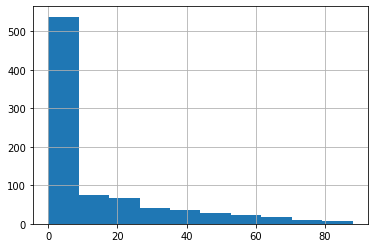

In [68]:
window_of_performance['days_since_last_driven'].hist()

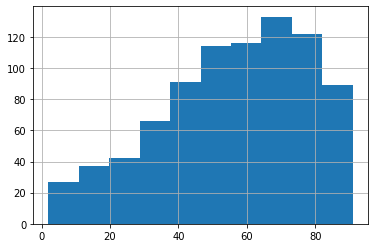

In [69]:
window_of_performance['how_many_will_leave'] = window_of_performance['days_driver_had_potential_to_drive'] - window_of_performance['days_since_last_driven']
window_of_performance['how_many_will_leave'].hist()

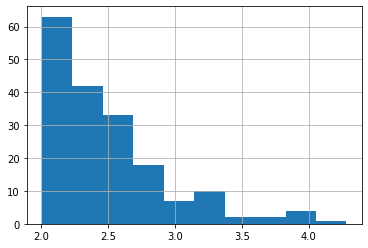

In [70]:
# finding the no of hours driven by a driver per day
hours_of_driving = df_ride_deets.groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index().groupby('driver_id')['ride_duration'].agg('mean').reset_index()
hours_of_driving['ride_duration'] = hours_of_driving['ride_duration']/3600 
hours_of_driving[hours_of_driving['ride_duration'] > 2]['ride_duration'].hist()
# these drivers have Lyft as their primary source of employement


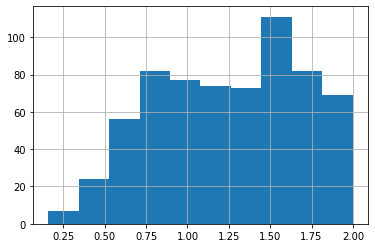

In [71]:
# no of hours put in by drivers who work with Lyft part time
hours_of_driving[hours_of_driving['ride_duration'] < 2]['ride_duration'].hist()


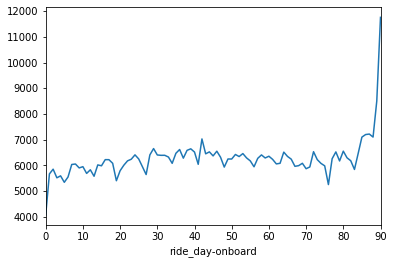

In [8]:
# time driven on an average as days since on boarding increases
df_ride_deets.groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index().groupby('ride_day-onboard')['ride_duration'].agg("mean").plot()

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 10 Text xticklabel objects>)

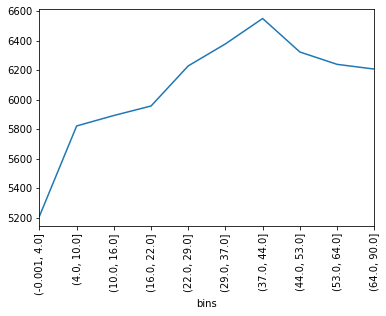

In [10]:
# creating bins for the previous data
l = df_ride_deets.groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index()
m = pd.qcut(l['ride_day-onboard'], 10)
l['bins'] = m
l.groupby('bins')['ride_duration'].agg("mean").plot()
plt.xticks(rotation=90)

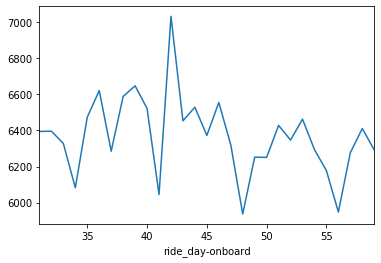

In [12]:
# zooming on on rides taking between the first and second month since onboarding
df_ride_deets[(df_ride_deets['ride_day-onboard'] > 30) & (df_ride_deets['ride_day-onboard'] < 60)].groupby(['driver_id', 'ride_day-onboard'])['ride_duration'].agg("sum").reset_index().groupby('ride_day-onboard')['ride_duration'].agg("mean").plot()


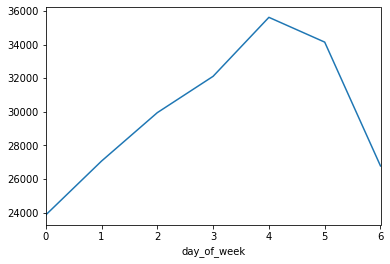

In [13]:
# plotting frquency of rides by day of the week
df_ride_deets.groupby(['driver_id', 'day_of_week'])['ride_duration'].agg("sum").reset_index().groupby('day_of_week')['ride_duration'].agg("mean").plot()

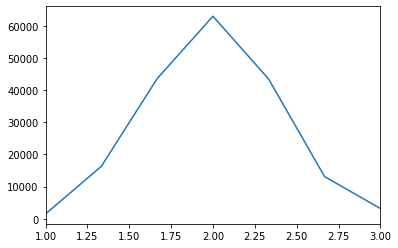

In [20]:
# distribution of drivers based on ratings
df_ride_deets['rating'].value_counts().sort_index().plot()

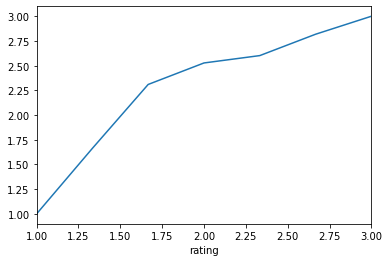

In [21]:
# fraction of holidays taken by drivers by rating
df_ride_deets.groupby('rating')['daysDrivenFraction'].agg('mean').plot()

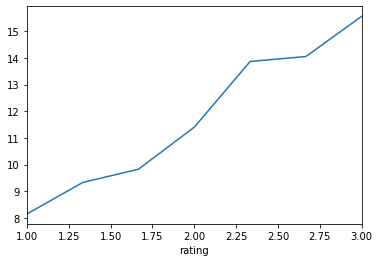

In [23]:
# time taken to accept a ride vs rating
df_ride_deets.groupby('rating')['accepted-requested'].agg('mean').plot()

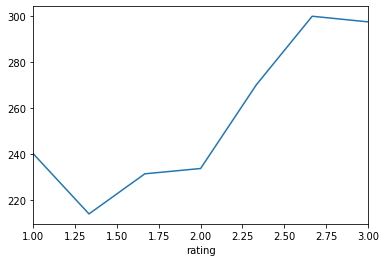

In [22]:
# time taken to get to location of user vs rating
df_ride_deets.groupby('rating')['arrived-accepted'].agg('mean').plot()

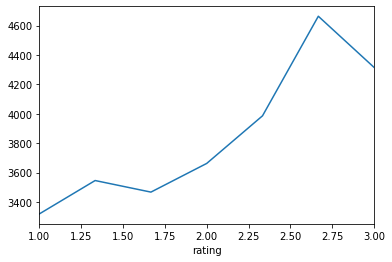

In [24]:
# time taken to locate user at pick-up point of user vs rating
df_ride_deets.groupby('rating')['pickedup-arrived'].agg('mean').plot()

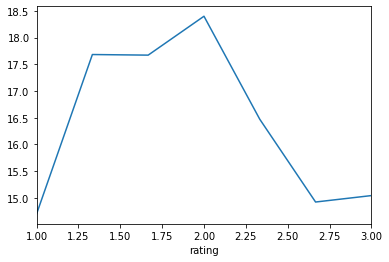

In [25]:
# frequency of prime-time-rides taken by driver vs rating
df_ride_deets.groupby('rating')['ride_prime_time'].agg('mean').plot()

In [26]:
# how does rating change day to day as days from onboard increases

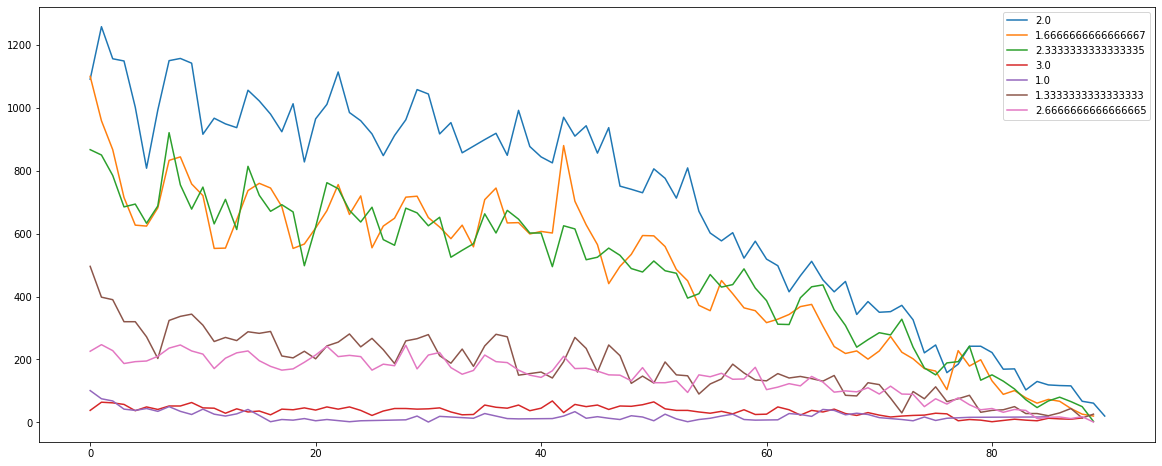

In [27]:
# plot for no of prime time rides vs ratings as days since onboarding increases
plt.rcParams["figure.figsize"] = [20,8]
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['ride_prime_time'].agg('count'), label = str(i))

plt.legend()

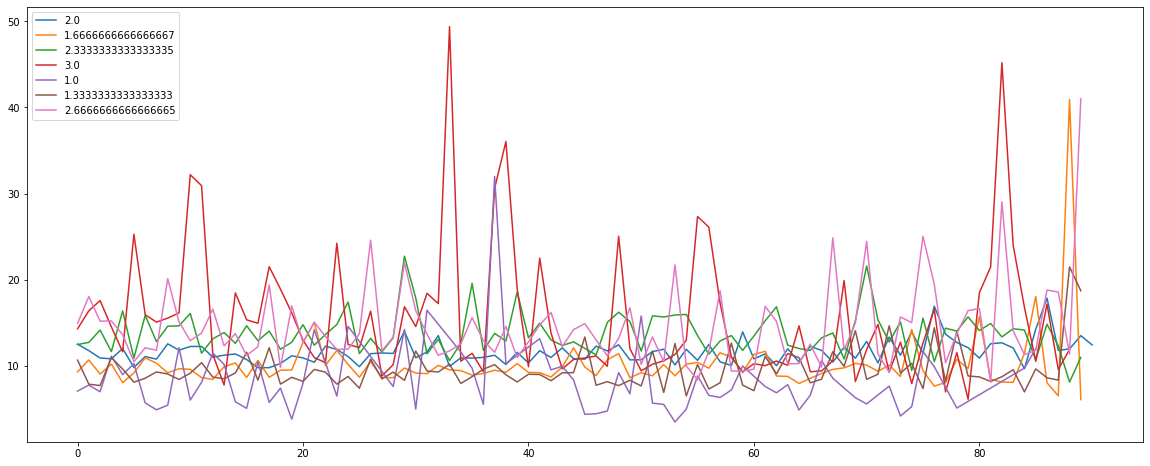

In [28]:
# plot for time taken to accept vs ratings as days since onboarding increases
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['accepted-requested'].agg('mean'), label = str(i))

plt.legend()

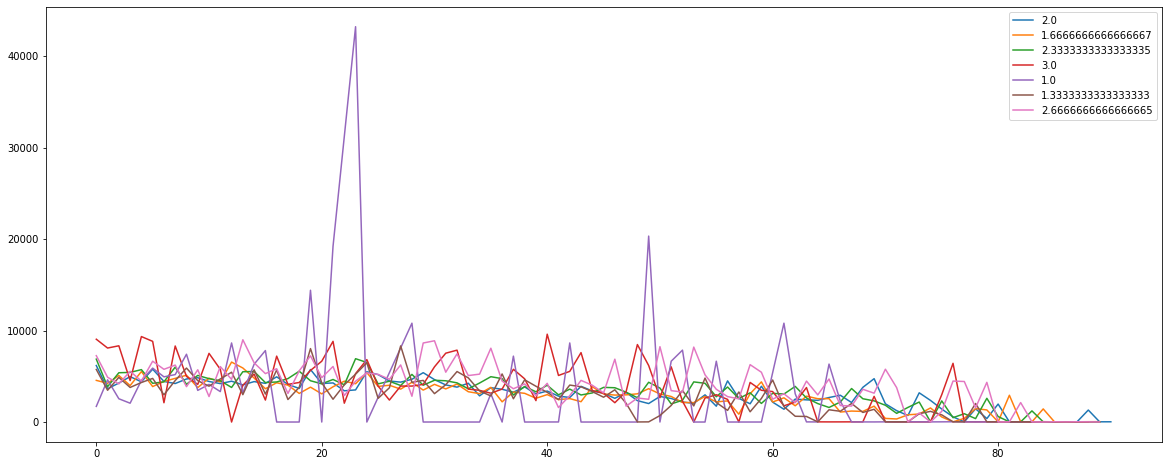

In [29]:
# plot for time taken to pick-up after arriving vs ratings as days since onboarding increases
for i in df_ride_deets['rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['rating'] == i].groupby('ride_day-onboard')['pickedup-arrived'].agg('mean'), label = str(i))

plt.legend()

In [33]:
# breaking the rating into three buckets to see clearer trennds
df_ride_deets['normalized_rating'] = pd.qcut(df_ride_deets['rating'], 3, labels=[1, 2, 3])

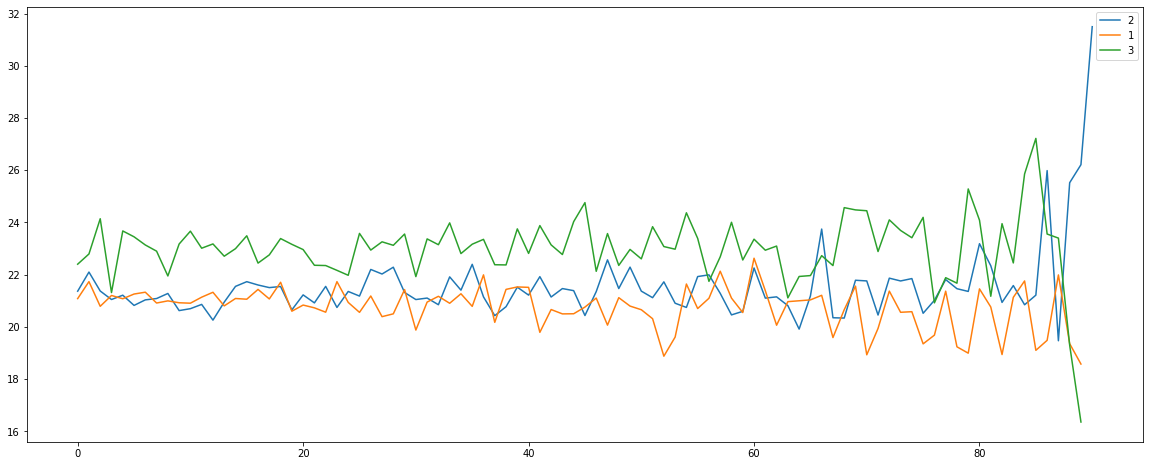

In [35]:
# plot of changes in fare for driver as days since onboarding increases for every rating
for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['adjusted_fare'].agg('mean'), label = str(i))

plt.legend()

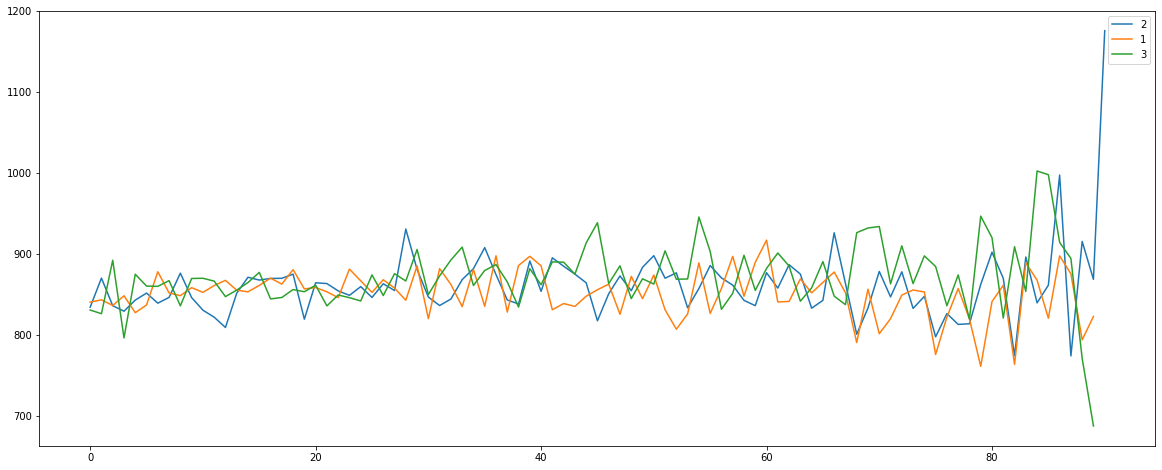

In [36]:
# plot of avaergae length of ride vs days since onboaring for every rating
for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['ride_duration'].agg('mean'), label = str(i))

plt.legend()

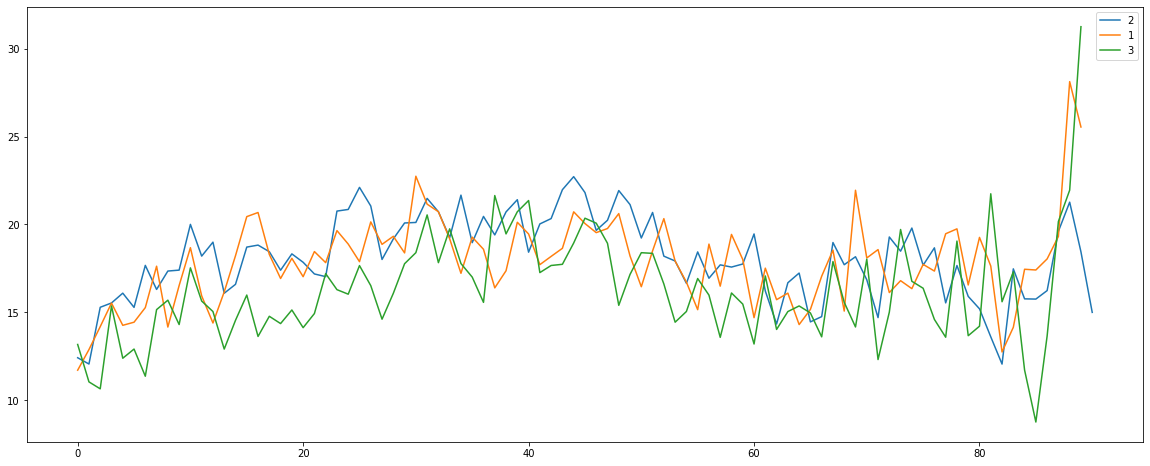

In [37]:
# plot of avaergae value of prime time rides vs days since onboaring for every rating

for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['ride_prime_time'].agg('mean'), label = str(i))

plt.legend()

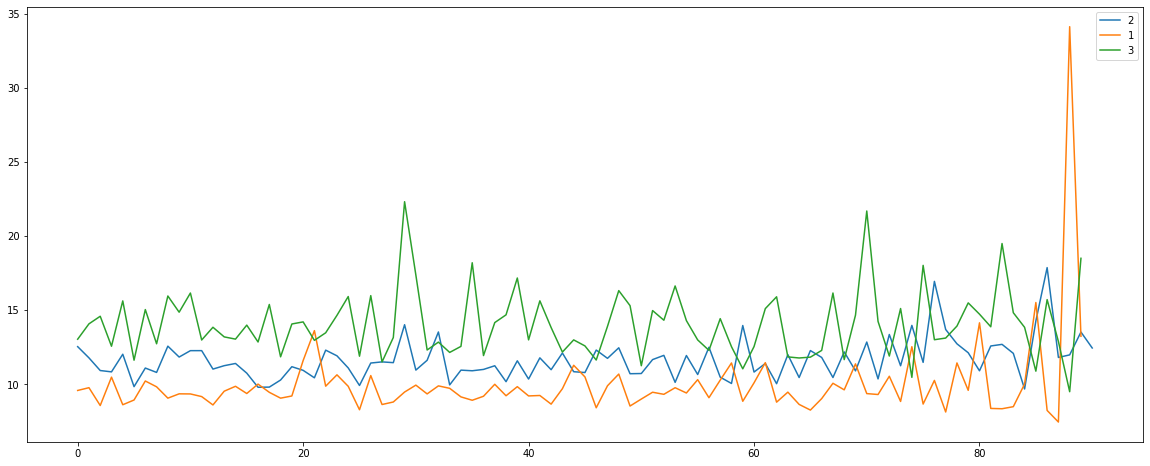

In [38]:
# plot of time taken to accept ride vs days since onboaring for every rating

for i in df_ride_deets['normalized_rating'].unique():
    plt.plot(df_ride_deets[df_ride_deets['normalized_rating'] == i].groupby('ride_day-onboard')['accepted-requested'].agg('mean'), label = str(i))

plt.legend()

In [41]:
# average fare of drivers who drive shorter rides
df_ride_deets[df_ride_deets['ride_duration'] <= 900]['adjusted_fare'].mean()

15.033128020747377

In [72]:
# average fare of drivers who drive longer rides
df_ride_deets[df_ride_deets['ride_duration'] > 900]['adjusted_fare'].mean()

33.865146301587544

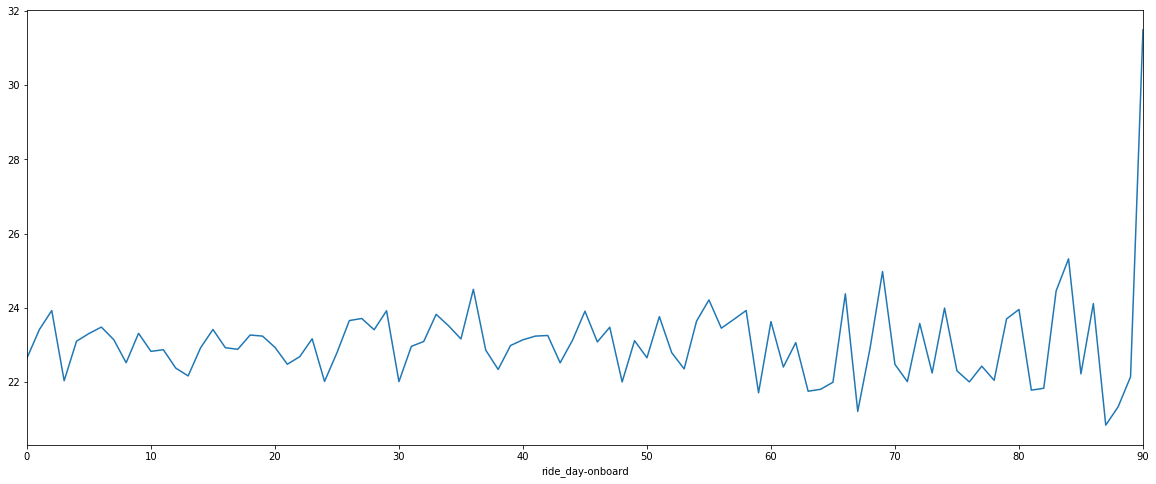

In [58]:
# average fare of driver vs days since onbaording
df_ride_deets.groupby(['driver_id', 'ride_day-onboard'])['adjusted_fare'].agg("mean").reset_index().groupby('ride_day-onboard')['adjusted_fare'].agg(mean).plot()